## The problem

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this project, I try to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [2]:

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import neighbors
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D
# from sklearn.tree import export_graphviz
# import graphviz


In [3]:
df_data = pd.read_csv('C:/Users/Or/Desktop/DataScienceProject/train.csv', na_values = ['NA'])
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Preparetion:

first - I will drop non-relevant columns: Cabin - that have a lot of missing data, and PassengerId, Ticket and Name that are irrelevant.

In [4]:
tickets_data = df_data['Ticket']
df_data.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)

Second - I will replace non-numeric values with numeric values. This is so that the modules can work with these values.

In [5]:

df_data.Sex.replace({'male':1, 'female':2}, inplace=True)
df_data.Embarked.replace({'C':1, 'Q':2, 'S':3}, inplace=True)

# features2 = features


Third thing - I need to complete missing data.  

from peeking the info() above - there is a lot of missing data in Age column, and a little in Embarked column.

In order to know which value to put in instead of NaN - I will use describe() function:

In [6]:
df_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000
mean,0.383838,2.308642,1.352413,29.699118,0.523008,0.381594,32.204208,2.535433
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.792088
min,0.000000,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,1.000000,20.125000,0.000000,0.000000,7.910400,2.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,3.000000
75%,1.000000,3.000000,2.000000,38.000000,1.000000,0.000000,31.000000,3.000000
max,1.000000,3.000000,2.000000,80.000000,8.000000,6.000000,512.329200,3.000000


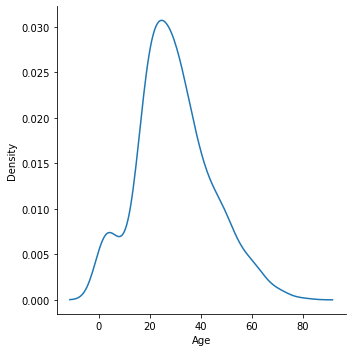

In [7]:
#sns.displot(df_data.Age)
sns.displot(df_data, x="Age", kind="kde")

it seems that the age distribution is unnormal and that the standard deviation is half the mean, hence most of the data are not close to the mean, and placing the mean in the missing places is not a good idea.
Therefore we will look for a correlation of age with other data : 

In [8]:
df_data.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.169718
Pclass,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.164681
Sex,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,-0.110320
Age,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.032565
SibSp,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,0.068900
Parch,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,0.040449
Fare,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,-0.226311
Embarked,-0.169718,0.164681,-0.110320,-0.032565,0.068900,0.040449,-0.226311,1.000000


I see that there is a relatively high correlation between age and Pclass.

Let's take a closer look at this:

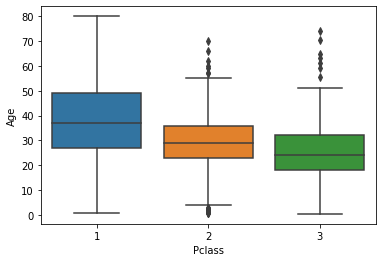

In [9]:
sns.boxplot(y='Age', x='Pclass', data = df_data)

That is, I can conclude the age by Pclass, for example taking the median of age in that Pclass:

In [10]:
age_medians = [0]
for i in range(1, 4):
    age_medians.append(df_data.query("Pclass==" + str(i)).Age.median())
print(age_medians)

[0, 37.0, 29.0, 24.0]


I'll complete the data according to the median age of the Pclass of that record

In [11]:
for ind,row in df_data.iterrows():
    if np.isnan(row.Age):
        df_data.loc[ind,'Age'] = age_medians[int(row.Pclass)]
        

In order to complete the data in Embarked - let's examine the distribution of this data:

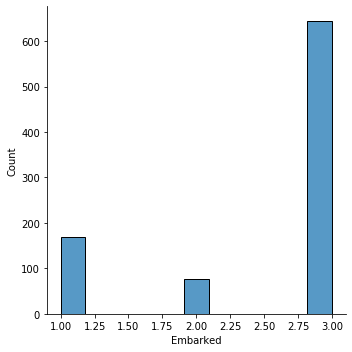

In [12]:
sns.displot(df_data.Embarked)

I see that most of the passengers arraive from Embarked 3 ('S'), So I will fill in the gaps  in Embarked with the most "popular" embarked:

In [13]:

df_data.Embarked.fillna(df_data.Embarked.mode()[0], inplace=True)

df_data["Sex"] = df_data["Sex"].astype('int64')
df_data["Embarked"] = df_data["Embarked"].astype('int64')

df_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,3
1,1,1,2,38.0,1,0,71.2833,1
2,1,3,2,26.0,0,0,7.9250,3
3,1,1,2,35.0,1,0,53.1000,3
4,0,3,1,35.0,0,0,8.0500,3


Now, that the data is valid - It's time to separete the data to train-dataset and test-dataset.

that because I want to draw conclusions and to build module on part of the data(train), and to check the truth against of new data (test).


In [14]:
classes = df_data['Survived']
features = df_data.drop(['Survived'], axis=1)

train_features, test_features, train_classes, test_classes = train_test_split(features, classes, test_size = 0.3, random_state = 42)

train_data = pd.concat([train_classes, train_features], axis=1)
test_data = pd.concat([test_classes, test_features], axis=1)

train_data.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
445,1,1,1,4.0,0,2,81.8583,3
650,0,3,1,24.0,0,0,7.8958,3
172,1,3,2,1.0,1,1,11.1333,3
450,0,2,1,36.0,1,2,27.7500,3
314,0,2,1,43.0,1,1,26.2500,3


## Understanding The Data

First - I want to check that the classes are divided reasonably

C:\Users\Or\miniconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


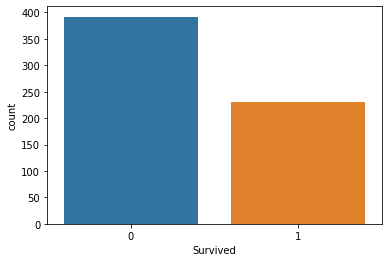

In [15]:
sns.countplot(train_classes, label='Count')

In wiki: https://he.wikipedia.org/wiki/%D7%98%D7%99%D7%98%D7%A0%D7%99%D7%A7 - I found facts about the Titanic story that Get along well with the distributions that we can see below:

we can see that there were far more female surviving than male, and more infants and children than adults. According to a letter in the wiki - The principle of "women and children first" caused the lifeboats to be filled by women and children mainly, and only a few men were allowed to enter the lifeboats.

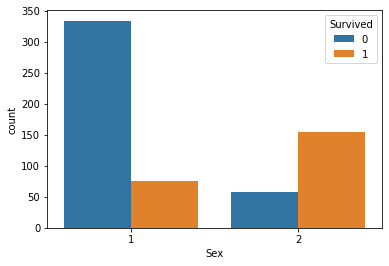

In [16]:
ax = sns.countplot(x="Sex", hue="Survived", data=train_data)

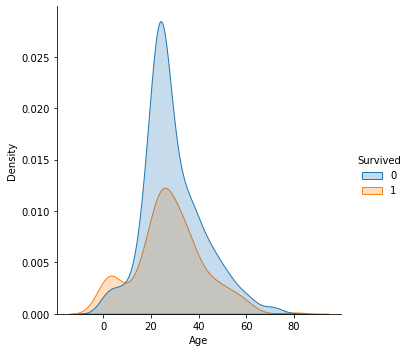

In [17]:
sns.displot(train_data, x="Age", hue="Survived", kind="kde", fill=True)

Also, it's seems that there is a relationship between the Pclass and the survivel. According to a letter in the wiki - most of the survivors were first and second class passengers, who were closer to the deck, and therefore also to the lifeboats, but the 
third class passengers was very far from the deck...

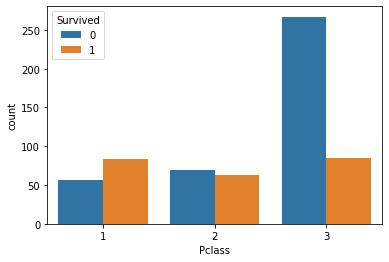

In [18]:
ax = sns.countplot(x="Pclass", hue="Survived", data=train_data)

Now, I want to examine the correlation between the rest of features and the survival chance.

Normalization of the data:

In [19]:
norm_train_features = StandardScaler().fit_transform(train_features)
norm_train_features = pd.DataFrame(norm_train_features, index=train_features.index, columns=train_features.columns)
norm_train_features

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
445,-1.637881,-0.720772,-1.863045,-0.474161,1.998853,0.980998,0.570005
650,0.803267,-0.720772,-0.351148,-0.474161,-0.479327,-0.469634,0.570005
172,0.803267,1.387401,-2.089830,0.348687,0.759763,-0.406136,0.570005
450,-0.417307,-0.720772,0.555990,0.348687,1.998853,-0.080232,0.570005
314,-0.417307,-0.720772,1.085154,0.348687,0.759763,-0.109651,0.570005
...,...,...,...,...,...,...,...
106,0.803267,1.387401,-0.577933,-0.474161,-0.479327,-0.474455,0.570005
270,-1.637881,-0.720772,0.631585,-0.474161,-0.479327,-0.016489,0.570005
860,0.803267,-0.720772,0.933964,1.171535,-0.479327,-0.347787,0.570005
435,-1.637881,1.387401,-1.107097,0.348687,1.998853,1.729074,0.570005


Now, I'm trying to find correlation between survivel and other feature. 
For that - I plot some visualizations:

In [20]:
norm_train_data = pd.concat([train_classes, norm_train_features], axis=1)
train_vis = pd.melt(norm_train_data, id_vars="Survived",
              var_name="features",
              value_name='value')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

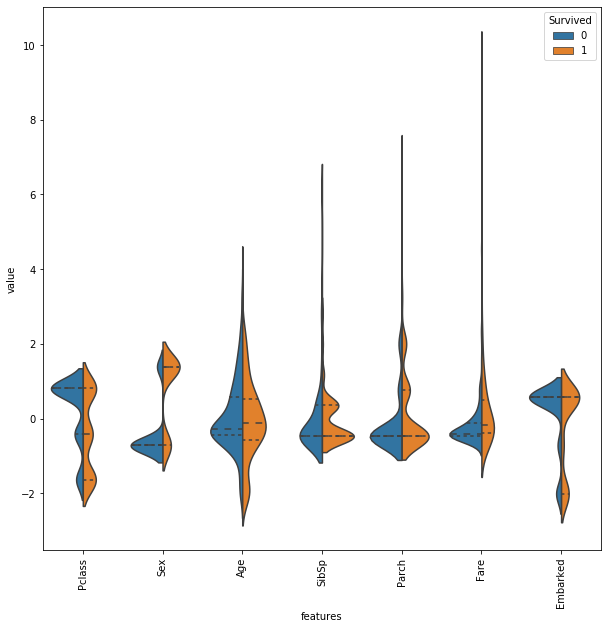

In [479]:
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="Survived", data=train_vis, split=True, inner="quart")
plt.xticks(rotation=90)

C:\Users\Or\miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 90.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Or\miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 93.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Or\miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Or\miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 84.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Or\miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 89.2% of the points cannot be

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

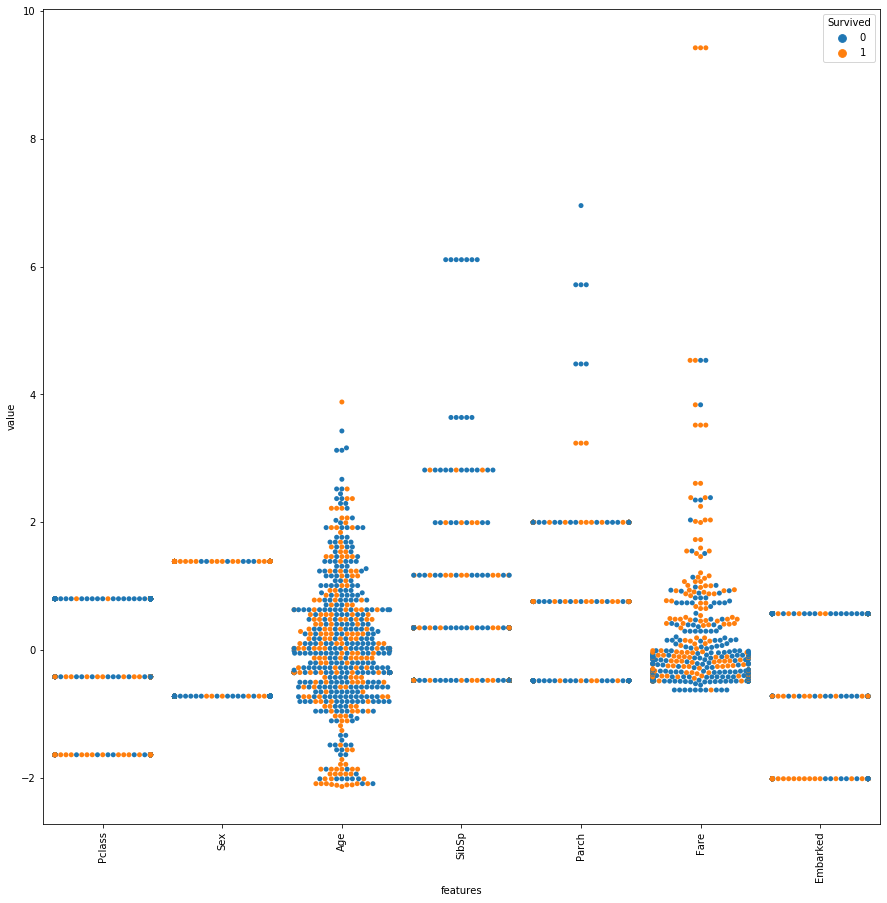

In [480]:

plt.figure(figsize=(15,15))
sns.swarmplot(x="features", y="value", hue="Survived", data=train_vis)
plt.xticks(rotation=90)

We find the correlations that found before.

Let's try to find corelation between the features:

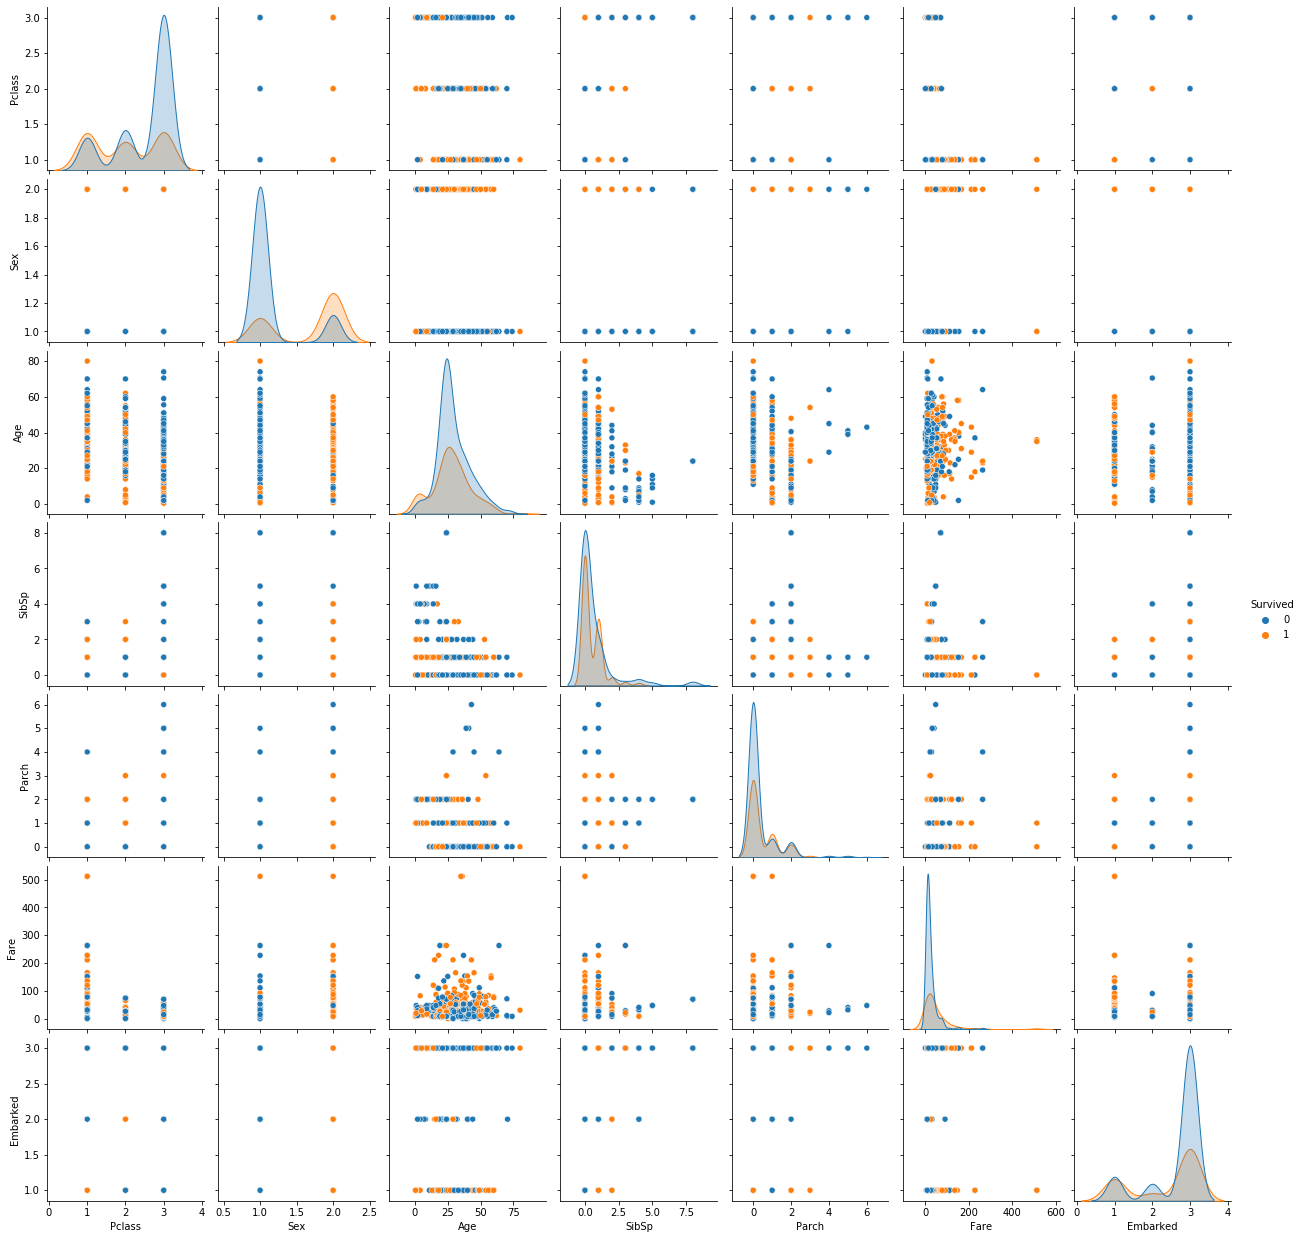

In [481]:
sns.pairplot(train_data, hue='Survived')

In [483]:
norm_train_features = StandardScaler().fit_transform(train_features)
norm_train_features = pd.DataFrame(norm_train_features, index=train_features.index, columns=train_features.columns)
norm_train_features

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
445,-1.637881,-0.720772,-1.863045,-0.474161,1.998853,0.980998,0.570005
650,0.803267,-0.720772,-0.351148,-0.474161,-0.479327,-0.469634,0.570005
172,0.803267,1.387401,-2.089830,0.348687,0.759763,-0.406136,0.570005
450,-0.417307,-0.720772,0.555990,0.348687,1.998853,-0.080232,0.570005
314,-0.417307,-0.720772,1.085154,0.348687,0.759763,-0.109651,0.570005
...,...,...,...,...,...,...,...
106,0.803267,1.387401,-0.577933,-0.474161,-0.479327,-0.474455,0.570005
270,-1.637881,-0.720772,0.631585,-0.474161,-0.479327,-0.016489,0.570005
860,0.803267,-0.720772,0.933964,1.171535,-0.479327,-0.347787,0.570005
435,-1.637881,1.387401,-1.107097,0.348687,1.998853,1.729074,0.570005


There is some relationship between the features, but it's hard to see that in the pairplot above, because the data is not continuous.

I will use heatmap:


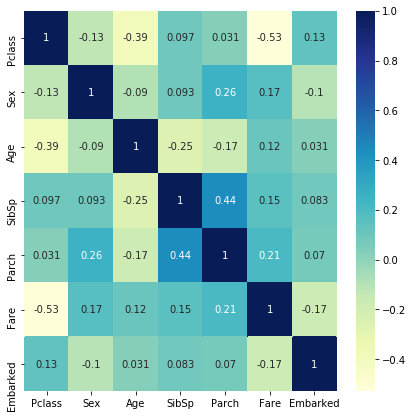

In [21]:
plt.figure(figsize=(7,7))
sns.heatmap(train_features.corr(), cmap="YlGnBu", annot=True)

Here we see there is a nice corelation between Pclass and Fare - that is make sense (firat class cost more than thirs class...),

also - we find correlation between SibSp and Parch - it's also make sense - if familiy was on the Titanic - Often it package deal of parents and children.

It also seems there is correlation between Age and Pclass. it's interesting.
But if I remember that plot:

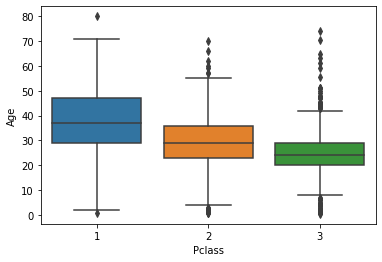

In [22]:
sns.boxplot(y='Age', x='Pclass', data = df_data)

I'm understanding it better. probably, more adults people have more money to pay for 1'st or 2'nd class tickets...

In [23]:
norm_features = StandardScaler().fit_transform(features)
norm_features = pd.DataFrame(norm_features, index=features.index, columns=features.columns)
norm_features

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.827377,-0.737695,-0.533834,0.432793,-0.473674,-0.502445,0.585954
1,-1.566107,1.355574,0.674891,0.432793,-0.473674,0.786845,-1.942303
2,0.827377,1.355574,-0.231653,-0.474545,-0.473674,-0.488854,0.585954
3,-1.566107,1.355574,0.448255,0.432793,-0.473674,0.420730,0.585954
4,0.827377,-0.737695,0.448255,-0.474545,-0.473674,-0.486337,0.585954
...,...,...,...,...,...,...,...
886,-0.369365,-0.737695,-0.156107,-0.474545,-0.473674,-0.386671,0.585954
887,-1.566107,1.355574,-0.760469,-0.474545,-0.473674,-0.044381,0.585954
888,0.827377,1.355574,-0.382743,0.432793,2.008933,-0.176263,0.585954
889,-1.566107,-0.737695,-0.231653,-0.474545,-0.473674,-0.044381,-1.942303


In [24]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(norm_features)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])
df_pca = pd.concat([principalDf, classes], axis = 1)

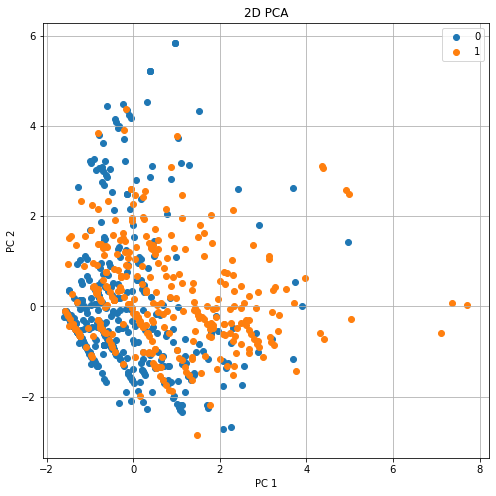

In [25]:


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('2D PCA')
colors = ['Blue', 'Red']
targets = [0, 1]
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['Survived'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC 1'],
               df_pca.loc[indicesToKeep, 'PC 2'],
              cmap=plt.cm.Spectral)
ax.legend(targets)
ax.grid()

It's not seems separable. so I tried to doing PCA with 3D:

In [26]:
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(norm_features)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2', 'PC 3'])

In [27]:
principalDf.head()

,PC 1,PC 2,PC 3
0,-1.377820,0.195220,0.299240
1,2.487055,-0.358196,-1.324310
2,-0.755738,0.160090,-0.424553
3,1.474010,-0.109846,0.559472
4,-1.163008,-0.770635,0.463005


In [28]:
df_pca = pd.concat([principalDf, classes], axis = 1)

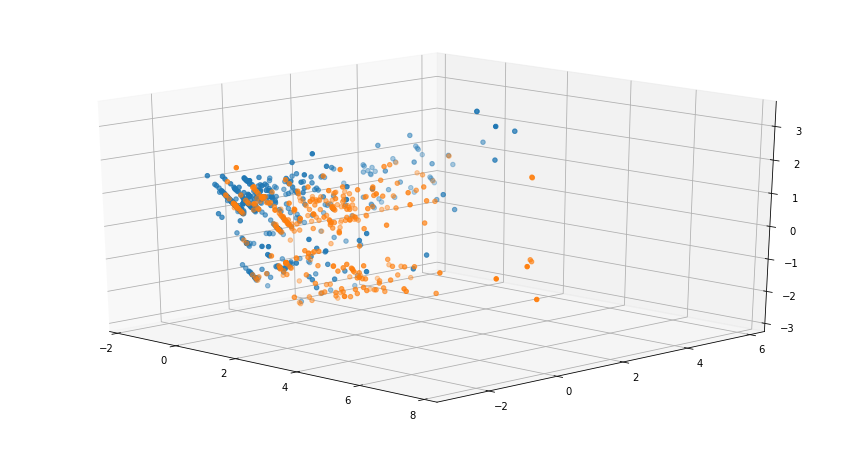

In [93]:

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111, projection='3d')
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('PC 1')
# ax.set_ylabel('PC 2')
# ax.set_title('2D PCA')
colors = ['Blue', 'Red']
targets = [0, 1]
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['Survived'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC 1'],
               df_pca.loc[indicesToKeep, 'PC 2'], 
               df_pca.loc[indicesToKeep, 'PC 3'],
              cmap=plt.cm.Spectral)
# ax.legend(targets)
# ax.grid()
ax.view_init(20, -45)

In [29]:
# from mpl_toolkits import mplot3d
# r = np.exp(-())

TypeError: bad operand type for unary -: 'tuple'

It steel not looking good. 

So I tried manifold:

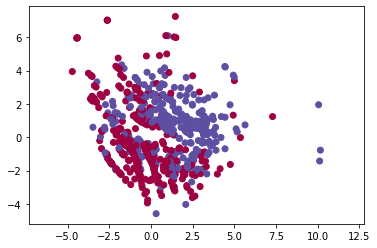

In [95]:

norm_data = pd.concat([classes, norm_features], axis=1)

model = MDS(n_components=2, random_state=1)
out = model.fit_transform(norm_data)
plt.scatter(out[:, 0], out[:, 1], c=classes, cmap=plt.cm.Spectral)
plt.axis('equal');

It seems a little bit better,

But still it hard to get good seperation for that data...

So I'll try another ways.

Here - I tried to use RandomForest classifier.

For find the best parameters - I'm using GridSearchCV from sklearn:

In [30]:
param_grid = {'n_estimators': [30, 50, 100, 200],
             'max_depth': [None,3,5],
             'random_state': [0,1,2],
             'min_samples_leaf': [1,6,10,20],
             'min_samples_split': [2,7,10,20]}

In [31]:
grid = GridSearchCV(RandomForestClassifier(),param_grid, refit=True, verbose=3)

In [82]:
grid.fit(train_features,train_classes)

In [90]:
grid.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50,
 'random_state': 0}

In [91]:
grid.best_estimator_.score(test_features, test_classes)

0.8208955223880597

In [32]:
model1 = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, min_samples_leaf=1, min_samples_split=10)
model1.fit(train_features,train_classes)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [33]:
print('RandomForest train score: ', model1.score(train_features,train_classes))
print('RandomForest test score: ', model1.score(test_features, test_classes))

RandomForest train score:  0.8635634028892456
RandomForest test score:  0.8208955223880597


In [95]:
model1.feature_importances_

array([0.1467811 , 0.46453041, 0.10846171, 0.04893975, 0.04329927,
       0.13552121, 0.05246655])

In [501]:
predictions = model1.predict(test_features)

In [502]:
print(confusion_matrix(test_classes, predictions))
print(classification_report(test_classes, predictions))

[[145  12]
 [ 36  75]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       157
           1       0.86      0.68      0.76       111

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.82      0.82       268



We got ~82% success, that nice. (and also the confusion matrix seems well :))

I will try yo run single tree from the forest:

In [34]:
print('Single tree train score: ', model1.estimators_[36].score(train_features,train_classes))
print('Single tree test score: ',model1.estimators_[36].score(test_features, test_classes))

Single tree train score:  0.8138041733547352
Single tree test score:  0.7761194029850746


Of course - the result that we got from singke tree is worse.

I will try ro run KNN - first on the Sex:

In [35]:
features_knn = train_features['Sex']
#features_knn = features2.drop(['Embarked', 'Parch', 'SibSp'], axis=1)
features_knn = features_knn.values.reshape(-1,1)

In [496]:
param_grid = {'n_neighbors': [5, 17, 25, 49],
             'weights': ['uniform','distance'],
             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid = GridSearchCV(neighbors.KNeighborsClassifier(),param_grid, refit=True, verbose=3, cv=3)
#grid.fit(features_knn,train_classes)

In [503]:
#grid.best_params_

In [504]:
test_features_knn = test_features['Sex'].values.reshape(-1,1)
#grid.best_estimator_.score(test_features_knn, test_classes)

In [36]:
model2 = neighbors.KNeighborsClassifier(19, weights='uniform')
model2.fit(features_knn, train_classes)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [38]:
test_features_knn = test_features['Sex'].values.reshape(-1,1)
print('KNN by Sex -  test score: ', model2.score(test_features_knn, test_classes))

KNN by Sex -  test score:  0.7910447761194029


In [508]:
predictions = model2.predict(test_features['Sex'].values.reshape(-1,1))
print(confusion_matrix(test_classes, predictions))
print(classification_report(test_classes, predictions))

[[134  23]
 [ 33  78]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       157
           1       0.77      0.70      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268



In [515]:
np.count_nonzero(test_features['Sex'].values.reshape(-1,1)==2)

101

In [521]:
len(test_data.loc[(test_data['Sex']==2)].loc[ (test_data['Survived']==0)])

23

I got at most 80% sucsses only with KNN on Sex data!
But that model is abnormal, of course, because the sex have only two options, so probably all female are in one side, and the male in the other side... (we can see it from the data above - the model was error on 23 female - the num of female in the data that didn't survive...)

So I coutinue to try KNN by Fare:

In [39]:
features_knn = train_features['Fare']
features_knn = features_knn.values.reshape(-1,1)

model2.fit(features_knn, train_classes)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [40]:
knn_test_data = test_features['Fare']
knn_test_data = knn_test_data.values.reshape(-1,1)

print('KNN by Fare -  test score: ',model2.score(knn_test_data, test_classes))

KNN by Fare -  test score:  0.7014925373134329


KNN by fare - only 70% success.

Trying KNN by all relevant fields:

In [83]:
grid.fit(train_features,train_classes)

In [152]:
grid.best_params_

{'algorithm': 'auto', 'n_neighbors': 49, 'weights': 'distance'}

In [121]:
grid.best_estimator_.score(test_features, test_classes)

0.6977611940298507

In [41]:
model2 = neighbors.KNeighborsClassifier(19, weights='uniform')
model2.fit(train_features, train_classes)
print('KNN by all features -  test score: ',model2.score(test_features, test_classes))

KNN by all features -  test score:  0.7164179104477612


In [537]:
predictions = model2.predict(test_features)
print(confusion_matrix(test_classes, predictions))
print(classification_report(test_classes, predictions))

[[141  16]
 [ 60  51]]
              precision    recall  f1-score   support

           0       0.70      0.90      0.79       157
           1       0.76      0.46      0.57       111

    accuracy                           0.72       268
   macro avg       0.73      0.68      0.68       268
weighted avg       0.73      0.72      0.70       268



KNN with all relevant features - ~71% success.

Using Neural Networks:

In [61]:


model3 = MLPClassifier(hidden_layer_sizes = [5,5,8],
                      solver='lbfgs',
                      random_state = 1).fit(train_features, train_classes)


print('MLP train score: ',  model3.score(train_features, train_classes))
print('MLP test score: ', model3.score(test_features, test_classes))



MLP train score:  0.812199036918138
MLP test score:  0.8134328358208955


In [577]:
predictions = model3.predict(test_features)
print(confusion_matrix(test_classes, predictions))
print(classification_report(test_classes, predictions))

[[139  18]
 [ 32  79]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       157
           1       0.81      0.71      0.76       111

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268



In [62]:
model4 = SVC(kernel='linear', C=0.05, probability=True)
model4.fit(train_features, train_classes)

print('SVC train score: ', model4.score(train_features, train_classes))
print('SVC train score: ', model4.score(test_features, test_classes))


SVC train score:  0.7849117174959872
SVC train score:  0.7910447761194029


In [63]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

model5 = MultinomialNB()
model5.fit(train_features, train_classes)

print('MultinomialNB train score: ', model5.score(train_features, train_classes))
print('MultinomialNB train score: ', model5.score(test_features, test_classes))

model6 = GaussianNB()
model6.fit(train_features, train_classes)

print('GaussianNB train score: ', model6.score(train_features, train_classes))
print('GaussianNB train score: ', model6.score(test_features, test_classes))

MultinomialNB train score:  0.680577849117175
MultinomialNB train score:  0.7014925373134329
GaussianNB train score:  0.7913322632423756
GaussianNB train score:  0.7985074626865671


## Voting

As last try - I tried to use voting to weigh all (or some of) the classifiers together,
but, steel I didn't success to break the glass ceiling of the Randon Forest Classifier - ~82%...

In [64]:
def voting(features):
    pred1 = model1.predict(features)
    pred2 = model2.predict(features)
    pred3 = model3.predict(features)
    pred4 = model3.predict(features)
    pred5 = model3.predict(features)
    pred6 = model3.predict(features)
    
    score = pred1 + pred2 + pred3
    
    if score >= 2:
        return 1;
    return 0;


In [80]:
def voting2(features):
    pred1 = model1.predict_proba(features)
#    pred2 = model2.predict_proba(features)
#     pred3 = model3.predict_proba(features)
   # pred4 = model4.predict_proba(features)
#     pred5 = model5.predict_proba(features)
    pred6 = model6.predict_proba(features)
    
    score = pred1  +pred6 # + pred6 
    
    if score[0][0] >= score[0][1]:
        return 0;
    return 1;

In [81]:
success = 0
failures = 0
for i in range(0, len(test_features)):
    a = model3.predict_proba(test_features.iloc[i].values.reshape(1, -1))
    if a[0][0] > 0.6:
        res = 0
    elif a[0][0] < 0.4:
        res = 1
    else:
        res = voting2(test_features.iloc[i].values.reshape(1, -1))
    if res == test_classes.iloc[i]:
        success += 1
    else:
        failures += 1
        
print('success: ', success)
print('failures: ', failures)
print(success/(success +failures))
    #print(type(test_features.iloc[i]))

success:  220
failures:  48
0.8208955223880597


I also tried to train female and male data seperately - but the results doesn't was Significantly better, so I droped it.
(maybe because the classifiers themselve did the separate between male and female...(?))

## Thank You!